In [61]:
%load_ext 

UsageError: Missing module name.


In [62]:
%autoreload 2

In [124]:
import numpy as np
import os
import sys; sys.path.insert(1, './classes/')
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import time

from elastostatic import *
from tools import *
from utilities import *

tol = 1e-10
components = ['V', 'N', 'E']
nature = ['Re', 'Im']
volumetric_output = False

In [64]:
def open_simple_grid(filename = '../stations/LandOceanGrid_x_2.0_y_2.0_bounds_-89_89_0_360.txt'):
    with open(filename, 'r') as file:
        return np.array([line.split() for line in file.readlines()], dtype=float)
    
def polar2compl(magn, phase):
    r = magn*np.cos(phase)
    i = magn*np.sin(phase)
    return r, i

def compl2polar(real, imag):
    absv  = np.linalg.norm([real, imag])
    phase = np.arctan2(imag, real)
    phase = phase if imag > 0 else 2*np.pi + phase
    return absv, phase

In [65]:
a = elastostatic_solver(meshfile = "../meshes/elastostatic/mesh.h5")
a.config.run.tensor_order = 1
a.construct_mesh(with_surface_topo = False, 
                 with_moho_topo = False, 
                 oneD_model="prem_iso_one_crust",
                 nex = 18, 
                 buffer = 0, 
                 local_refinement_level=0, 
                 global_refinement_level=0)

sph_crd = get_sph_coord(a.mesh)
a.prepare_mesh_fields(real_or_imag = 're')

def dist(x):
    #return np.abs(1221501. - np.linalg.norm(x, axis=-1))
    return np.abs(3480000. - np.linalg.norm(x, axis=-1))
a.mesh.find_side_sets_generic("r0", dist, tolerance=10.)

a.write_mesh(path = a.meshfile)

./classes/octiload_class.py:95: UserWarning: min_z below CMB, including fluid with mu=0 as elastic
  self.mesh = ms.create_mesh(verbose=True)


number of elements:  17928
amp 0.14937283 0.1910651
re 7.761588e-05 0.16453516
im -2.6916323e-05 0.17817493
sea_mask_grad 2.0402913 7.001373
attaching elastic parameters

SUCCESSFULLY GENERATED MESH IN 3.75975 SECONDS.
the mesh has been written to ../meshes/elastostatic/mesh.h5


In [66]:
regular_grid = open_simple_grid()

In [67]:
indices = [str(ind) for ind in regular_grid[:,2].astype(int)]
side_points = get_gps_stations(indeces = indices, latitudes = regular_grid[:,0], longitudes = regular_grid[:,1],)

In [68]:
receivers = {f'{station.name}':{'SidePoint': station} for station in side_points}

In [69]:
with open("../stations/cn_OceanOnly_GOT410c-M2_cm_convgf_GOT410c_global_PREM.txt") as file:
    data = np.array([line.split() for line in file.readlines()])
header = data[0]
regular_grid = data[1:].astype(float)

indices     = [str(ind) for ind in regular_grid[:,0].astype(int)]
east_ri     = np.array([polar2compl(magn, np.radians(phase)) for magn, phase in zip(regular_grid[:,3], regular_grid[:,4])])/1000.
north_ri    = np.array([polar2compl(magn, np.radians(phase)) for magn, phase in zip(regular_grid[:,5], regular_grid[:,6])])/1000.
vert_ri     = np.array([polar2compl(magn, np.radians(phase)) for magn, phase in zip(regular_grid[:,7], regular_grid[:,8])])/1000.
side_points = get_gps_stations(indeces = indices, latitudes = regular_grid[:,1], longitudes = regular_grid[:,2],)

In [70]:
receivers = {f'{station.name}':{'SidePoint': station, 
                                'lat': lat, 'lon': lon,   
                                'E-Re-LD': e_re, 'E-Im-LD': e_im, 
                                'N-Re-LD': n_re, 'N-Im-LD': n_im, 
                                'V-Re-LD': v_re, 'V-Im-LD': v_im,
                                'E-Ab-LD': e_ab, 'E-Ph-LD': e_ph,
                                'N-Ab-LD': n_ab, 'N-Ph-LD': n_ph,
                                'V-Ab-LD': v_ab, 'V-Ph-LD': v_ph} 
             for station,
                 lat, lon,
                 e_re, e_im, 
                 n_re, n_im, 
                 v_re, v_im,
                 e_ab, e_ph,
                 n_ab, n_ph,
                 v_ab, v_ph
             in 
             zip(side_points,
                 regular_grid[:,1], regular_grid[:,2],
                 east_ri [:,0], east_ri [:,1], 
                 north_ri[:,0], north_ri[:,1], 
                 vert_ri [:,0], vert_ri [:,1],
                 regular_grid[:,3], regular_grid[:,4],
                 regular_grid[:,5], regular_grid[:,6],
                 regular_grid[:,7], regular_grid[:,8])
            }

**Running real part simulation**

In [76]:
assert len(ssh_keys_from_agent()) > 0, "No SSH keys found"

AssertionError: No SSH keys found

In [12]:
a.prepare_mesh_fields(real_or_imag = 're')

a.config.elastos_run.relative_tolerance = 1e-10
a.config.run.ranks                      = 10
a.config.run.wall_time_in_seconds       = 3600
a.config.elastos_run.max_iterations     = 6000
a.config.elastos_run.point_solution     = a.config.elastos_run.solution_folder + "receivers_re.h5"
a.config.elastos_run.volume_solution    = a.config.elastos_run.solution_folder +  "solution_re.h5"
a.config.run.site_name                  = 'daint'
sim_re                                  = a.run_simulation(stations = side_points)

a.mesh.attach_field('NEUMANN_re', a.mesh.elemental_fields['NEUMANN'])

Locating 16020 item(s)::   0%|          | 0/16020 [00:00<?, ?it/s]

/home/admitrov/miniconda3/envs/salvus/lib/python3.7/site-packages/salvus/flow/sites/__init__.py:132: SalvusFlowWarning: Configuration for site 'daint' changed since itwas last initialized. Please initialize it again.
  skip_version_number_check=skip_version_number_check,
/home/admitrov/miniconda3/envs/salvus/lib/python3.7/site-packages/salvus/flow/sites/__init__.py:132: UserWarning: The version number of the Salvus Python package '0.12.6.post13+g507827e3' differs from the version number of site "daint": '0.11.44-45-g2e039420'. We strongly recommend to use the same version number for both. Otherwise we cannot guarantee that it works as intended.
  skip_version_number_check=skip_version_number_check,
Exception (client): Error reading SSH protocol banner
Traceback (most recent call last):
  File "/home/admitrov/miniconda3/envs/salvus/lib/python3.7/site-packages/paramiko/transport.py", line 2278, in _check_banner
    buf = self.packetizer.readline(timeout)
  File "/home/admitrov/miniconda3

SSHException: Error reading SSH protocol banner

Minimal rel.error^2: 5.8673e-11


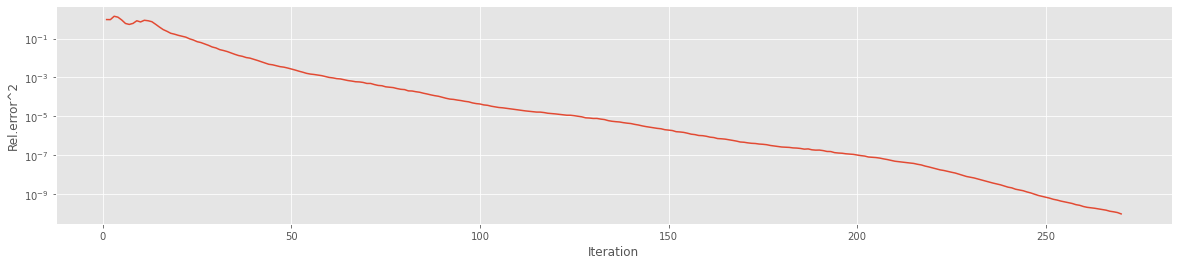

In [122]:
with open('../solutions/elastostatic/stdout') as file:
    data      = np.array(file.readlines())
    begin     = np.where(data == '----- BEGIN ITERATION LOG -----\n')[0][0] + 5
    end       = np.where(data == '----- END ITERATION LOG -----\n')[0][0]
    data      = data[begin:end]
    rel_error = np.array([line.split() for line in data], dtype=np.float64)
plt.figure(figsize=(20, 4))
plt.semilogy(rel_error[:,0], rel_error[:,2])
plt.xlabel('Iteration')
plt.ylabel('Rel.error^2')
print('Minimal rel.error^2:', np.min(rel_error))
plt.savefig('convergence.png')